```source ~/miniconda3/bin/activate rlpy3p6```

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [57]:
import os
import numpy as np
import pandas as pd
import glob
import math

In [5]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('input/train_1', event_prefix))

In [6]:
def get_features(df):
    x = df.x.values
    y = df.y.values
    z = df.z.values

    r = np.sqrt(x**2 + y**2 + z**2)

    x2 = x/r
    y2 = y/r

    r2 = np.sqrt(x**2 + y**2)
    z2 = z/r2
    
    df['x2'] = x2
    df['y2'] = y2
    df['z2'] = z2
    df['r2'] = r2
    df['r'] = r
    
    
    # eta, and phi
    theta = np.arccos(z/r)
    phi = np.arctan2(y, x)
    eta = - np.log(np.tan(theta/2.))
    df['eta'] = eta
    df['phi'] = phi
    df['absZ'] = np.abs(z)
    
    return df

In [7]:
hits_more = get_features(hits)
hits_more.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2,r2,r,eta,phi,absZ
0,1,-64.409897,-7.163700,-1502.5,7,2,1,-0.042829,-0.004763,-23.184208,64.807045,1503.896973,-3.837108,-3.030827,1502.5
1,2,-55.336102,0.635342,-1502.5,7,2,1,-0.036804,0.000423,-27.150467,55.339748,1503.518799,-3.994889,3.130112,1502.5
2,3,-83.830498,-1.143010,-1502.5,7,2,1,-0.055707,-0.000760,-17.921406,83.838287,1504.837158,-3.579932,-3.127959,1502.5
3,4,-96.109100,-8.241030,-1502.5,7,2,1,-0.063835,-0.005474,-15.576118,96.461777,1505.593262,-3.439919,-3.056055,1502.5
4,5,-62.673599,-9.371200,-1502.5,7,2,1,-0.041676,-0.006232,-23.709833,63.370335,1503.835815,-3.859459,-2.993168,1502.5


In [8]:
all_info = hits.merge(truth, on='hit_id')

In [9]:
all_info.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2,...,phi,absZ,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,-64.409897,-7.163700,-1502.5,7,2,1,-0.042829,-0.004763,-23.184208,...,-3.030827,1502.5,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,-55.336102,0.635342,-1502.5,7,2,1,-0.036804,0.000423,-27.150467,...,3.130112,1502.5,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,-83.830498,-1.143010,-1502.5,7,2,1,-0.055707,-0.000760,-17.921406,...,-3.127959,1502.5,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,-96.109100,-8.241030,-1502.5,7,2,1,-0.063835,-0.005474,-15.576118,...,-3.056055,1502.5,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,-62.673599,-9.371200,-1502.5,7,2,1,-0.041676,-0.006232,-23.709833,...,-2.993168,1502.5,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


In [11]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824902,1,3


In [49]:
cells.head()

,hit_id,ch0,ch1,value
0,1,209,617,0.013832
1,1,210,617,0.079887
2,1,209,618,0.211723
3,2,68,446,0.334087
4,3,58,954,0.034005


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aab17fb44e0>]],
      dtype=object)

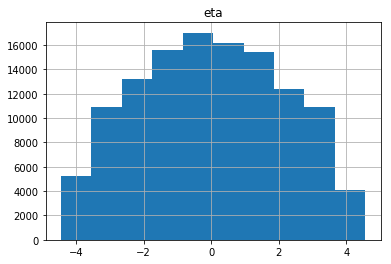

In [8]:
hits_more.hist("eta")

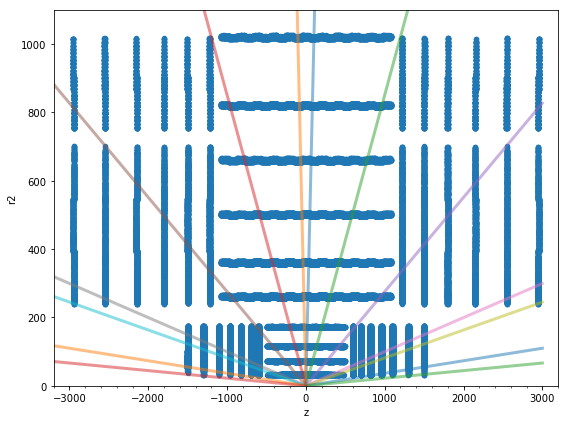

In [114]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
hits_more.plot.scatter(x='z', y='r2', ax=ax)
eta = [0.1, 1, 2, 3, 3.2, 4, 4.5]
# eta = - np.log(np.tan(theta/2.))
theta = [2*math.atan(math.exp(-x)) for x in eta]
xp = np.arange(0, 3200, 200)
xm = np.arange(-3200, 200, 200)
for th in theta:
    yp = xp*np.tan(th)
    ym = xm*np.tan(-1*th)
    ax.plot(xp, yp, '-', alpha=0.5, lw=3)
    ax.plot(xm, ym, '-', alpha=0.5, lw=3)

ax.set_xlim(-3200, 3200)
ax.set_ylim(0, 1100)
ax.xaxis.set_minor_locator(loc)
plt.tight_layout()
plt.show()

In [12]:
all_info.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2,...,eta,phi,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,-64.409897,-7.163700,-1502.5,7,2,1,-0.042829,-0.004763,-23.184208,...,-3.837108,-3.030827,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,-55.336102,0.635342,-1502.5,7,2,1,-0.036804,0.000423,-27.150467,...,-3.994889,3.130112,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,-83.830498,-1.143010,-1502.5,7,2,1,-0.055707,-0.000760,-17.921406,...,-3.579932,-3.127959,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,-96.109100,-8.241030,-1502.5,7,2,1,-0.063835,-0.005474,-15.576118,...,-3.439919,-3.056055,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,-62.673599,-9.371200,-1502.5,7,2,1,-0.041676,-0.006232,-23.709833,...,-3.859459,-2.993168,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


In [11]:
non_zero_pID = all_info[all_info['particle_id'] != 0]['particle_id']
non_zero_pID_weight = all_info[(all_info['weight'] > 5E-7) & (all_info['particle_id'] != 0) ]['particle_id']

In [17]:
type(non_zero_pID)

pandas.core.series.Series

In [ ]:
comsic_pp = []
for p in non_zero_pID:
    data = all_info[all_info['particle_id'] == p][['r', 'eta', 'phi', 'z', 'absZ']].sort_values(by=['absZ'])
    if data['r'].iloc[0] > data['r'].iloc[1] and data['r'].iloc[1] > data['r'].iloc[2]:
        comsic_pp.append(p)

In [15]:
data = pick_event(571961413283610624).sort_values(by=['z'])

In [16]:
data.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2,...,eta,phi,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
24838,24839,31.617901,4.8272,171.423004,8,2,153,0.181315,0.027682,5.359603,...,2.380629,0.151503,571961413283610624,31.618200,4.826220,171.421997,0.590935,0.100511,3.13807,0.000014
32888,32889,70.618599,12.3683,379.019989,8,4,401,0.183073,0.032064,5.286670,...,2.367162,0.173384,571961413283610624,70.619301,12.365500,379.028015,0.587035,0.125490,3.13724,0.000012
47646,47647,111.463997,21.9853,598.000000,9,2,57,0.183119,0.036119,5.263551,...,2.362859,0.194742,571961413283610624,111.466003,21.966000,598.000000,0.579337,0.149125,3.13672,0.000010
47728,47729,112.206001,22.1532,602.000000,9,2,59,0.183113,0.036153,5.263526,...,2.362853,0.194926,571961413283610624,112.205002,22.156099,602.000000,0.579166,0.148564,3.13632,0.000008
50699,50700,130.628006,27.0508,702.000000,9,4,59,0.182808,0.037856,5.262390,...,2.362638,0.204196,571961413283610624,130.628998,27.057800,702.000000,0.575198,0.160697,3.13596,0.000007


In [19]:
data['r'].iloc[0] > data['r'].iloc[-1]

False

In [113]:
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=200)
loc0p4 = plticker.MultipleLocator(base=0.4)
def view(pID, numb=10, pp=None):
    fig = plt.figure(figsize=(15, 12))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224, projection='polar')
    if pp is None:
        pp = pID.sample(numb)
        
    for p in pp:
        data = all_info[all_info['particle_id'] == p][['r2', 'eta', 'phi', 'z', 'absZ']].sort_values(by=['absZ']).values
        ax1.plot(data[:,3], data[:,0], '-', alpha=0.5, lw=4, label='{}'.format(p))
        ax1.scatter(data[:,3], data[:,0], marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)        

        ax2.plot(data[:,3], data[:,1], '-', alpha=0.5, lw=4, label='{}'.format(p))
        ax2.scatter(data[:,3], data[:,1], marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)

        ax3.plot(np.abs(data[:,3]), data[:,2], '-', alpha=0.5, lw=4, label='{}'.format(p))
        ax3.scatter(np.abs(data[:,3]), data[:,2], marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)

        
        ax4.plot(data[:,2], np.abs(data[:,3]), '-', alpha=0.5, lw=4, label='{}'.format(p))
        ax4.scatter(data[:,2], np.abs(data[:,3]), marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
        
    ax1.set_xlabel("Z [mm]")
    ax1.set_ylabel("r [mm]")
    ax1.xaxis.set_minor_locator(loc)
    ax1.set_xlim(-3200, 3200)
    ax1.set_ylim(0, 1100)

        
    ax2.set_xlabel("Z [mm]")
    ax2.set_ylabel("eta")
    ax2.yaxis.set_minor_locator(loc0p4)
    ax2.xaxis.set_minor_locator(loc)
    ax2.set_xlim(-3200, 3200)
    ax2.set_ylim(-5, 5)
    ax2.grid(True)
    
    ax3.set_xlabel("Z [mm]")
    ax3.set_ylabel("phi")
    ax3.xaxis.set_minor_locator(loc)
    ax3.set_xlim(-3200, 3200)
    ax3.set_ylim(-np.pi, np.pi)
    
    ax4.grid(True)
    if numb < 12:
        ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.tight_layout()
    plt.show()
    return pp

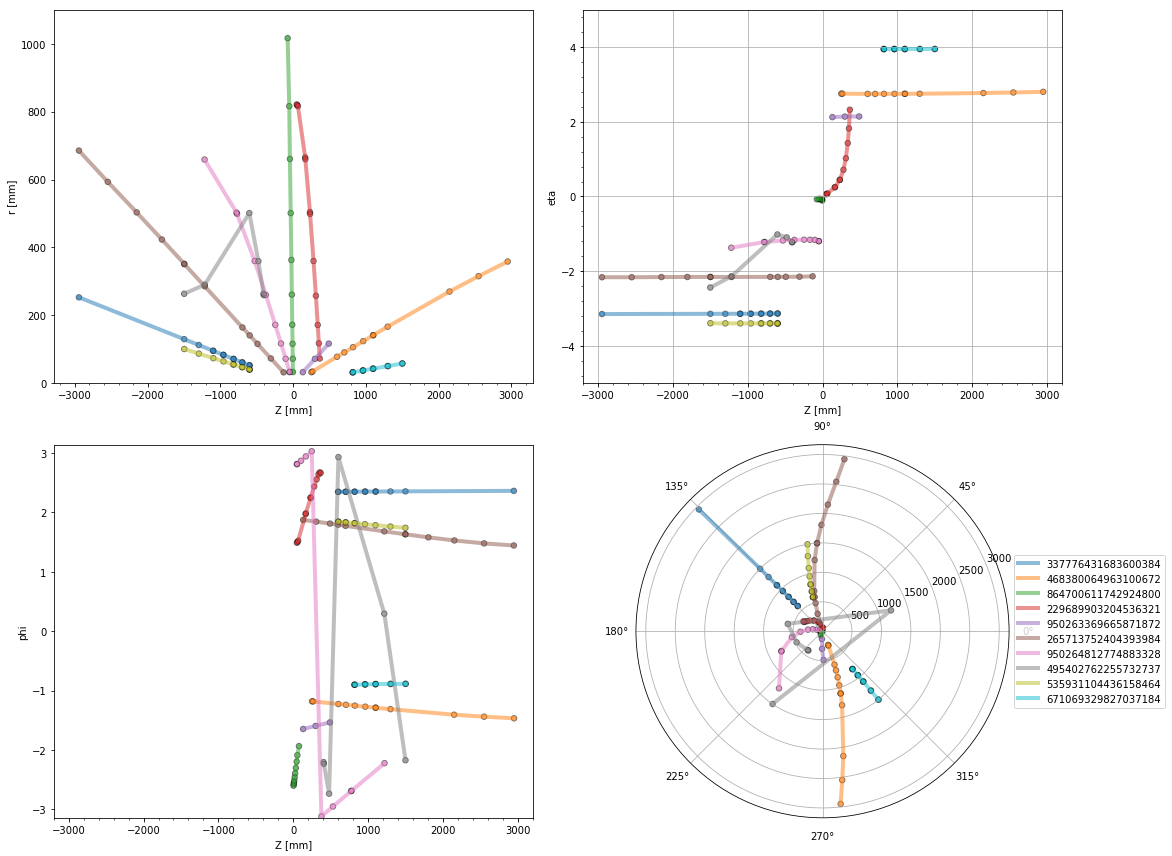

In [111]:
p10 = view(non_zero_pID, pp=p10)

In [26]:
plot_one()

7657     337776431683600384
55940    468380064963100672
19351    864700611742924800
45416    229689903204536321
23753    950263369665871872
67884    265713752404393984
35107    950264812774883328
79498    495402762255732737
10280    535931104436158464
56117    671069329827037184
Name: particle_id, dtype: int64

In [115]:
test_p1 = 229689903204536321
test_p2 = 337776431683600384
test_ps = [229689903204536321, 337776431683600384, 495402762255732737]
test_p3 = test_ps[2]

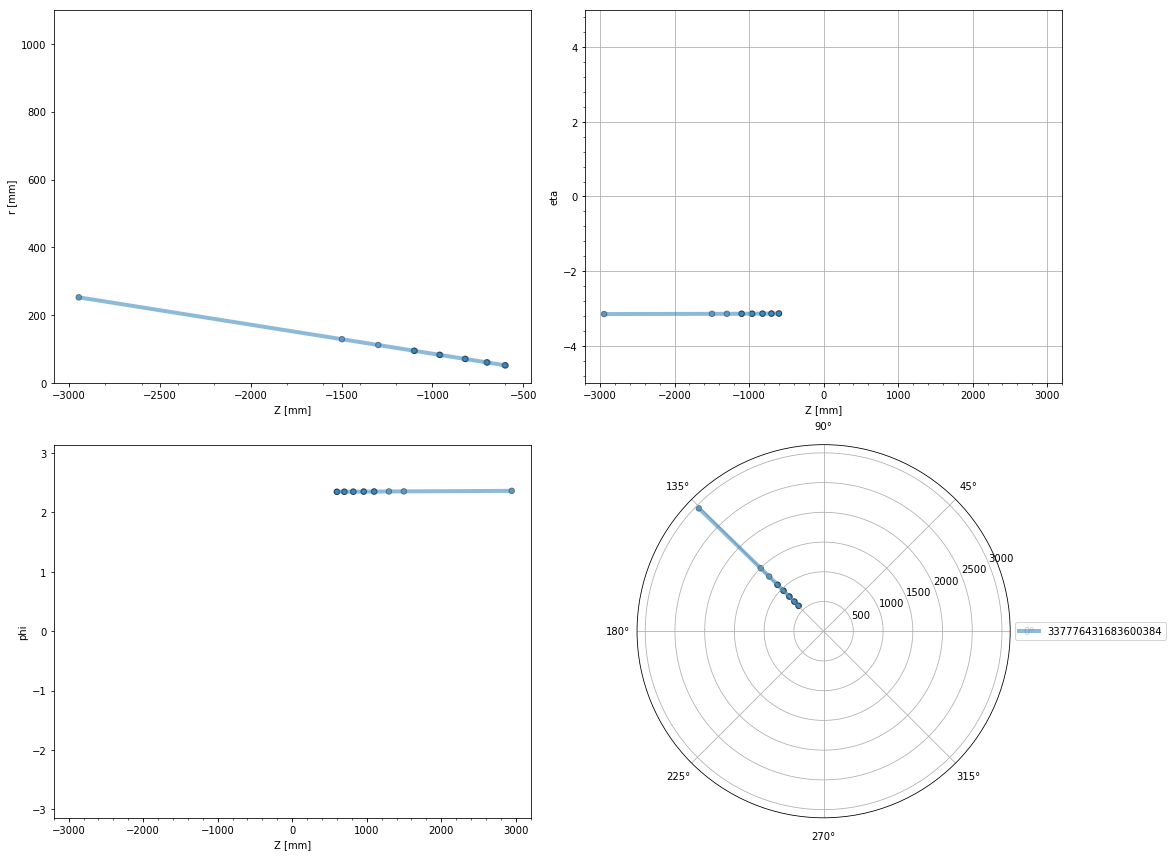

             particle_id        vx        vy       vz       px       py  \
4679  337776431683600384  0.002332 -0.023655  9.00641 -2.04008  2.09609   

             pz  q  nhits  
4679 -34.090199 -1     13  


,x,y,z,eta,phi,volume_id,layer_id,module_id,tpx,tpy,tpz,r
1281,-91.289703,91.466499,-1498.0,-3.145307,2.355227,7,2,95,-2.08521,2.04357,-34.071602,1503.563721
3015,-79.052299,79.441200,-1298.0,-3.144453,2.353741,7,4,95,-2.07986,2.05041,-34.072300,1302.829224
5107,-67.075401,67.641296,-1102.0,-3.143279,2.351994,7,6,93,-2.07397,2.05827,-34.072300,1106.109619
5161,-66.812103,67.353500,-1097.5,-3.143287,2.352159,7,6,96,-2.07679,2.05711,-34.072701,1101.592773
7608,-58.574100,59.150398,-962.0,-3.142244,2.351299,7,8,93,-2.07221,2.06237,-34.072701,965.594971
7657,-58.288399,58.889999,-957.5,-3.142202,2.351060,7,8,96,-2.07348,2.06148,-34.073299,961.078491
10418,-50.042801,50.701199,-822.0,-3.140738,2.349659,7,10,93,-2.06940,2.06620,-34.073399,825.081116
10522,-49.765999,50.427601,-817.5,-3.140713,2.349591,7,10,96,-2.07012,2.06445,-34.074200,820.564392
13464,-42.773201,43.421398,-702.0,-3.138903,2.348675,7,12,93,-2.06627,2.06867,-34.074299,704.640991
13527,-42.527199,43.127300,-697.5,-3.138760,2.349189,7,12,96,-2.06237,2.06802,-34.075901,700.124817


In [112]:
view(non_zero_pID, pp=pd.Series([test_p2]))
print(particles[particles['particle_id'] == test_p2])
pick_event(test_p2)[['x', 'y', 'z','eta', 'phi', 'volume_id','layer_id','module_id', 'tpx', 'tpy', 'tpz', 'r']]

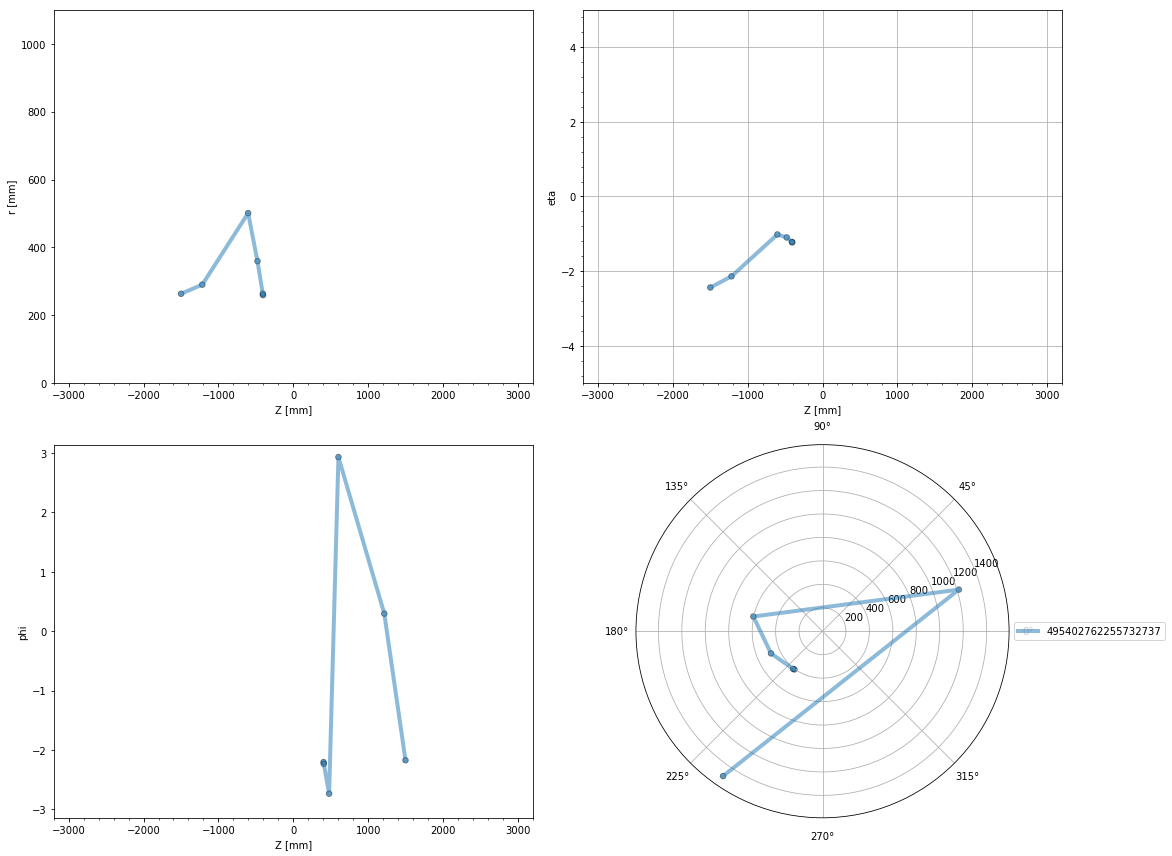

             particle_id          vx          vy          vz        px  \
6370  495402762255732737 -145.848999 -209.647995 -400.932007 -0.237875   

            py        pz  q  nhits  
6370  0.024791 -0.093601  1      6  


,x,y,z,eta,phi,volume_id,layer_id,module_id,tpx,tpy,tpz,r
68450,-148.947998,-216.968994,-1498.500000,-2.440173,-2.172400,12,10,27,-0.223322,0.021182,-0.113113,1521.434570
70499,277.437012,84.710098,-1215.500000,-2.139841,0.296340,12,12,93,-0.050981,-0.221289,-0.110181,1249.634888
72667,-162.227997,-207.621002,-407.799988,-1.220943,-2.234071,13,2,246,-0.235443,0.034140,-0.093133,485.515442
72681,-153.455002,-208.802994,-404.200012,-1.227509,-2.204581,13,2,247,-0.236214,0.028409,-0.093332,480.129974
79498,-329.997009,-142.093994,-478.399994,-1.097523,-2.734995,13,4,284,-0.192439,0.135457,-0.096764,598.293640
86315,-489.908997,104.285004,-603.000000,-1.018447,2.931857,13,6,388,-0.041641,0.231062,-0.095730,783.897461


In [116]:
view(non_zero_pID, pp=pd.Series([test_p3]))
print(particles[particles['particle_id'] == test_p3])
pick_event(test_p3)[['x', 'y', 'z','eta', 'phi', 'volume_id','layer_id','module_id', 'tpx', 'tpy', 'tpz', 'r']]

In [ ]:
view(non_zero_pID, pp=pd.Series([test_p1]))

In [41]:
particles[particles['particle_id'] == test_p1]
pick_event(test_p1)

,particle_id,vx,vy,vz,px,py,pz,q,nhits
3619,229689903204536321,-26.2535,19.082199,376.75,-0.242183,0.076612,-0.074408,1,12


In [43]:
pick_event(test_p1)

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2,...,phi,absZ,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
32999,33000,-64.071297,33.095402,365.312012,8,4,414,-0.172067,0.088880,5.065753,...,2.664801,365.312012,229689903204536321,-64.071503,33.094898,365.313995,-0.233349,0.099079,-0.071544,0.000012
39620,39621,-104.593002,52.578400,352.713989,8,6,673,-0.281441,0.141479,3.012979,...,2.675791,352.713989,229689903204536321,-104.592003,52.581402,352.709991,-0.222257,0.120989,-0.070849,0.000011
45416,45417,-150.276001,82.070000,337.242004,8,8,930,-0.397324,0.216990,1.969572,...,2.641727,337.242004,229689903204536321,-150.276001,82.069504,337.242004,-0.202418,0.150336,-0.071398,0.000009
76507,76508,-214.539993,142.035004,312.000000,13,2,557,-0.530505,0.351218,1.212610,...,2.556797,312.000000,229689903204536321,-214.533997,142.042007,312.122009,-0.162135,0.189466,-0.073532,0.000007
83194,83195,-273.976013,233.369003,279.600006,13,4,778,-0.601166,0.512065,0.776895,...,2.436063,279.600006,229689903204536321,-273.987000,233.360001,279.842010,-0.106798,0.222628,-0.073541,0.000006
89243,89244,-314.167999,393.968994,230.600006,13,6,1003,-0.566930,0.710934,0.457632,...,2.243976,230.600006,229689903204536321,-314.148987,393.979004,230.268005,-0.009115,0.246455,-0.071079,0.000004
89251,89252,-313.833008,387.510986,231.800003,13,6,1004,-0.570712,0.704697,0.464851,...,2.251526,231.800003,229689903204536321,-313.842987,387.505005,232.143005,-0.013587,0.246269,-0.071336,0.000005
95083,95084,-260.794006,611.956970,164.600006,13,8,1307,-0.380570,0.893013,0.247441,...,1.973652,164.600006,229689903204536321,-260.807007,611.955017,164.955002,0.120973,0.214460,-0.069026,0.000004
95085,95086,-265.000000,604.265991,167.000000,13,8,1308,-0.389348,0.887810,0.253099,...,1.984087,167.000000,229689903204536321,-265.014008,604.262024,167.442001,0.115770,0.217175,-0.069801,0.000004
110329,110330,66.059402,818.593994,48.599998,17,2,1289,0.080297,0.995019,0.059178,...,1.490272,48.599998,229689903204536321,66.088501,818.586975,53.527100,0.244972,0.020823,-0.063777,0.000007


In [44]:
pick_event(test_p1)[['eta', 'phi', 'z']]

,eta,phi,z
32999,2.325253,2.664801,365.312012
39620,1.822543,2.675791,352.713989
45416,1.429944,2.641727,337.242004
76507,1.024021,2.556797,312.000000
83194,0.714524,2.436063,279.600006
89243,0.443000,2.243976,230.600006
89251,0.449555,2.251526,231.800003
95083,0.244983,1.973652,164.600006
95085,0.250472,1.984087,167.000000
110329,0.059143,1.490272,48.599998


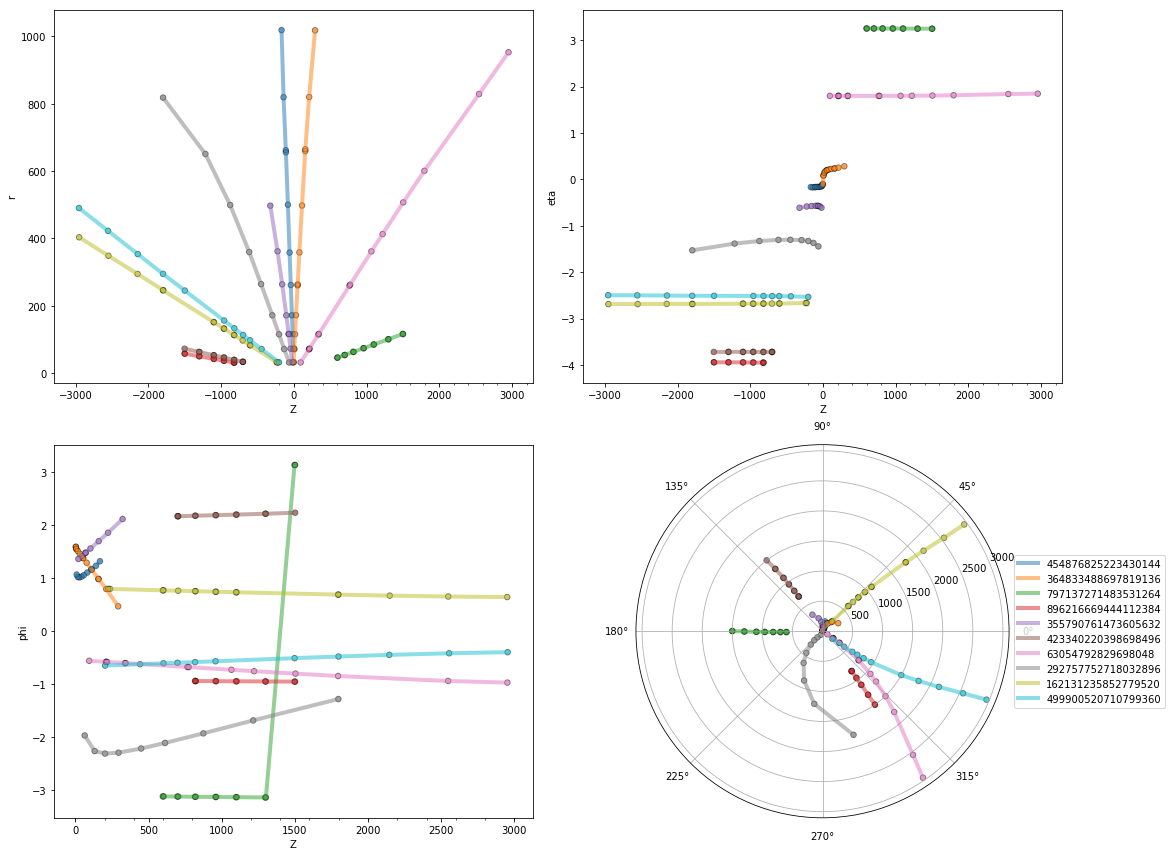

In [33]:
pp10_2 = track_view(numb=10)

In [32]:
pick_event(495400631951953921).sort_values(by=['z'])

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2,...,eta,phi,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
66007,66008,139.126999,-420.936005,-2154.5,12,6,51,0.063250,-0.191366,-4.859787,...,-2.284563,-1.251582,495400631951953921,139.029007,-420.649994,-2154.5,-0.141928,-0.104411,-0.405042,0.000020
67390,67391,242.533005,-300.117004,-1795.5,12,8,62,0.132063,-0.163418,-4.653171,...,-2.242046,-0.891119,495400631951953921,242.477005,-300.062988,-1795.5,-0.085993,-0.165014,-0.402724,0.000010
68801,68802,280.131012,-166.399002,-1498.5,12,10,71,0.182673,-0.108508,-4.599093,...,-2.230621,-0.535999,495400631951953921,279.998993,-166.322006,-1498.5,-0.012991,-0.195895,-0.399999,0.000018
70426,70427,262.118988,-29.651100,-1218.5,12,12,83,0.210246,-0.023783,-4.619192,...,-2.234884,-0.112642,495400631951953921,261.984985,-29.673901,-1218.5,0.065878,-0.191375,-0.397991,0.000033


(-300, 300)

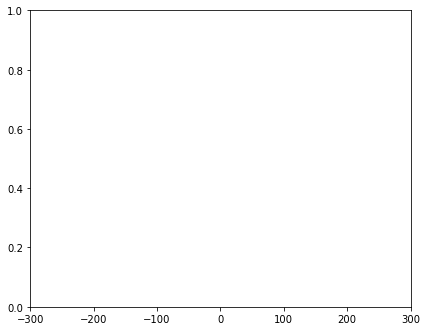

In [34]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(221)
ax1.set_xlim(-300, 300)

(-300, 300)

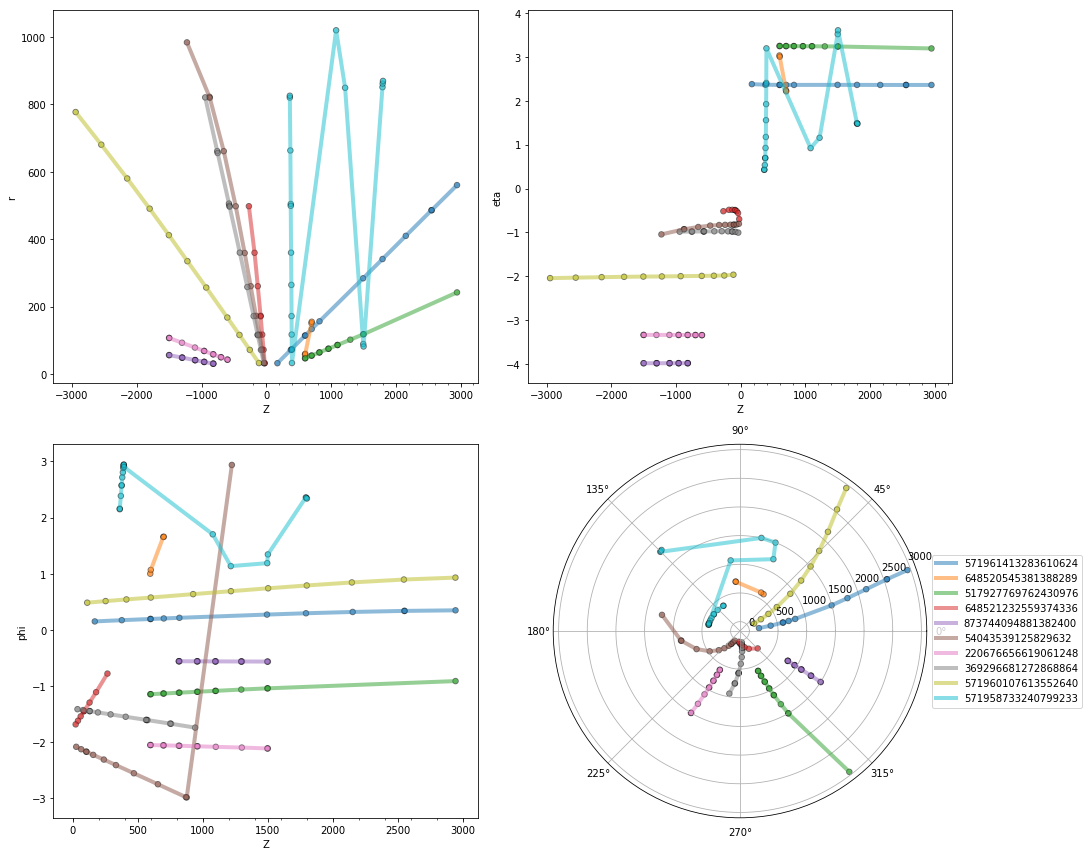

In [16]:
pp10 = track_view(numb=10, tmp_pp=pp10)

In [27]:
def pick_event(pID):
    return all_info[all_info['particle_id'] == pID]

In [17]:
pp10

103087    571961413283610624
51395     648520545381388289
103997    517927769762430976
74021     648521232559374336
574       873744094881382400
35224      54043539125829632
233       220676656619061248
19833     369296681272868864
105040    571960107613552640
76894     571958733240799233
Name: particle_id, dtype: int64

In [28]:
def plot_one(p):
    fig = plt.figure(figsize=(15, 12))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224, projection='polar')        
    
    # data = all_info[all_info['particle_id'] == p][['r', 'eta', 'phi', 'z']].sort_values(by=['z']).values
    data = all_info[all_info['particle_id'] == p][['r', 'eta', 'phi', 'z']].values
    ax1.plot(data[:,3], data[:,0], '-', alpha=0.5, lw=4, label='{}'.format(p))
    ax1.scatter(data[:,3], data[:,0], marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
    ax1.xaxis.set_minor_locator(loc)
    ax1.xaxis.set


    ax2.plot(data[:,3], data[:,1], '-', alpha=0.5, lw=4, label='{}'.format(p))
    ax2.scatter(data[:,3], data[:,1], marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
    ax2.xaxis.set_minor_locator(loc)

    ax3.plot(np.abs(data[:,3]), data[:,2], '-', alpha=0.5, lw=4, label='{}'.format(p))
    ax3.scatter(np.abs(data[:,3]), data[:,2], marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
    ax3.xaxis.set_minor_locator(loc)

    ax4.plot(data[:,2], np.abs(data[:,3]), '-', alpha=0.5, lw=4, label='{}'.format(p))
    ax4.scatter(data[:,2], np.abs(data[:,3]), marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
        


    ax1.set_xlabel("Z")
    ax1.set_ylabel("r")
    ax2.set_xlabel("Z")
    ax2.set_ylabel("eta")
    ax3.set_xlabel("Z")
    ax3.set_ylabel("phi")
    ax4.grid(True)
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.tight_layout()
    plt.show()

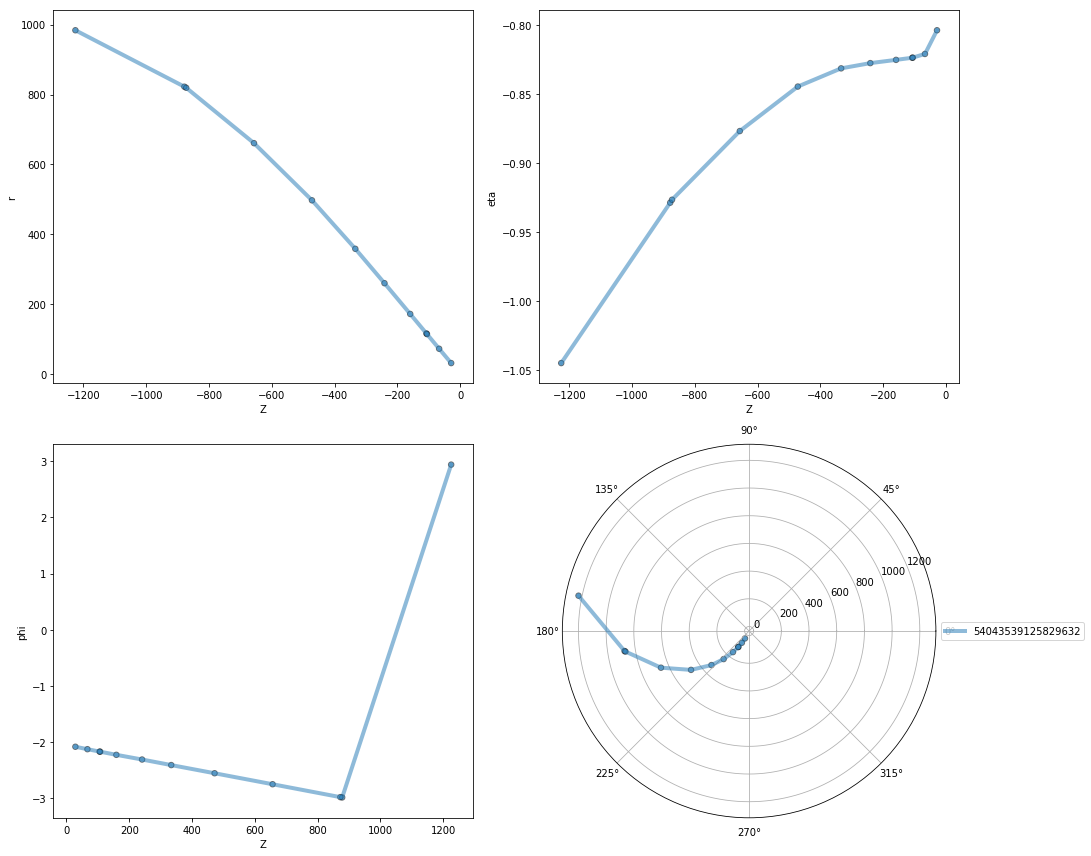

In [25]:
plot_one(54043539125829632)

It's likely a cosmic ray event: 571958733240799233

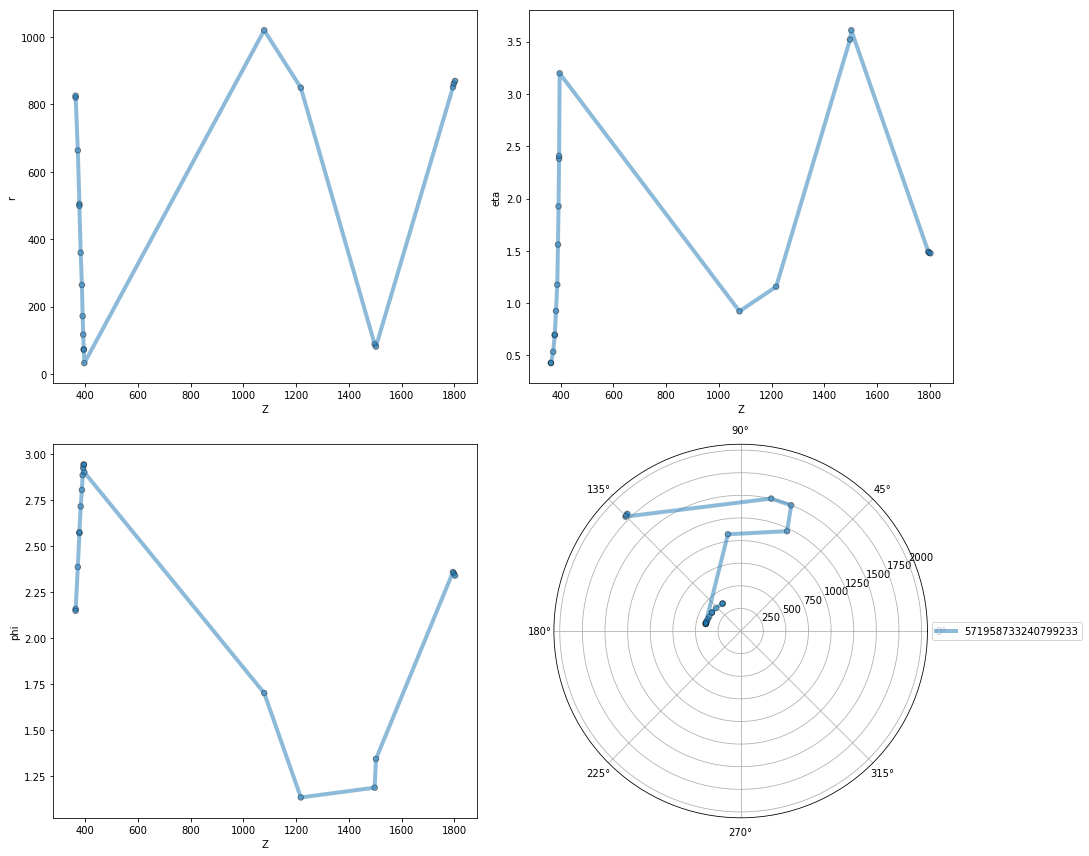

In [21]:
plot_one(571958733240799233)

In [24]:
jj = pick_event(571958733240799233)
jj.sort_values(by=['z'])

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2,...,eta,phi,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
111508,111509,-454.644989,682.195984,363.399994,17,2,1782,-0.506994,0.760746,0.443272,...,0.429906,2.158644,571958733240799233,-454.632996,682.202026,364.273010,0.103403,0.269528,-0.005823,0.000002
111505,111506,-450.983002,691.254028,363.399994,17,2,1781,-0.500082,0.766511,0.440293,...,0.427182,2.148866,571958733240799233,-451.069000,691.216980,364.078003,0.110141,0.266722,-0.006710,0.000002
95697,95698,-482.671997,454.574005,371.799988,13,8,1518,-0.634960,0.597997,0.560758,...,0.534886,2.386165,571958733240799233,-482.683014,454.565002,371.821991,-0.033966,0.287777,-0.009925,0.000002
89953,89954,-423.989014,272.894989,377.799988,13,6,1163,-0.672938,0.433128,0.749275,...,0.692567,2.569704,571958733240799233,-423.985992,272.898010,377.884003,-0.141869,0.253651,-0.009243,0.000003
89956,89957,-420.919006,267.531006,377.799988,13,6,1164,-0.672736,0.427583,0.757503,...,0.699139,2.575416,571958733240799233,-420.920013,267.528992,378.066010,-0.145782,0.251545,-0.008532,0.000004
83589,83590,-327.625000,148.880997,382.600006,13,4,837,-0.623752,0.283448,1.063173,...,0.925346,2.715065,571958733240799233,-327.622986,148.884003,382.880005,-0.220938,0.208438,-0.009605,0.000004
76894,76895,-249.283997,87.321297,387.399994,13,2,598,-0.531661,0.186235,1.466672,...,1.176133,2.804661,571958733240799233,-249.283997,87.321198,386.958008,-0.256560,0.164136,-0.012502,0.000005
45721,45722,-166.063995,43.623402,390.091003,8,8,1011,-0.389634,0.102353,2.271958,...,1.559040,2.884706,571958733240799233,-166.063995,43.622200,390.071014,-0.283252,0.116871,-0.010947,0.000005
39635,39636,-114.166000,25.316401,392.227997,8,6,675,-0.278937,0.061855,3.354117,...,1.924852,2.923373,571958733240799233,-114.166000,25.318001,392.230988,-0.294418,0.088418,-0.013848,0.000006
33011,33012,-72.217903,14.627500,394.252991,8,4,416,-0.180059,0.036470,5.350564,...,2.378970,2.941750,571958733240799233,-72.217903,14.627400,394.238007,-0.301338,0.063352,-0.015625,0.000007


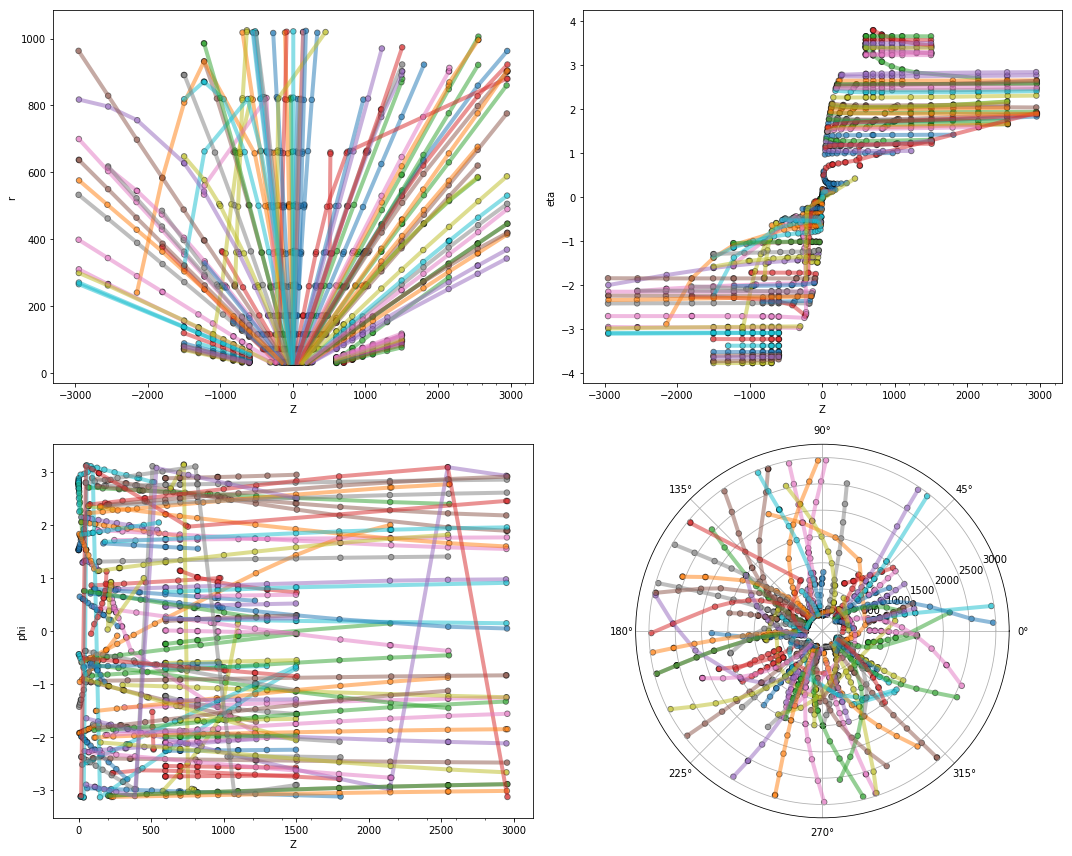

In [31]:
pp100 = track_view(tmp_pp=pp100)

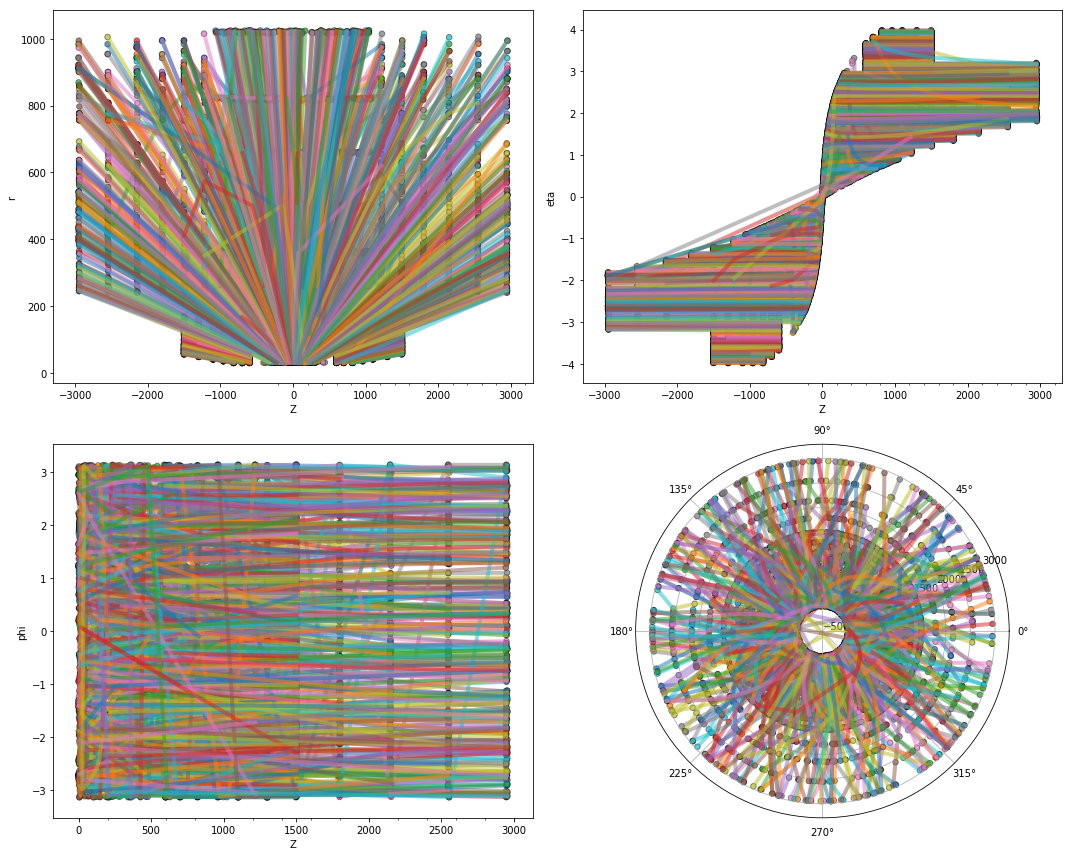

In [33]:
pp1000 = track_view(numb=1000)

In [15]:
cells.head()

,hit_id,ch0,ch1,value
0,1,209,617,0.013832
1,1,210,617,0.079887
2,1,209,618,0.211723
3,2,68,446,0.334087
4,3,58,954,0.034005


In [24]:
max_charge = cells.groupby('hit_id').agg({'value': np.max})

,value
hit_id,
1,0.211723
2,0.334087
3,0.099964
4,0.323907
5,0.296566


In [25]:
max_chargeCP = max_charge.copy()

In [ ]:
max_chargeCP.reindex(index=np.arange(len(max_chargeCP)), columns=)

In [22]:
pd.concat([max_charge, cells], axis=1, join='outer', keys=['hit_id', 'value'])

hit_id   value                      
           value  hit_id   ch0   ch1     value
0            NaN       1   209   617  0.013832
1       0.211723       1   210   617  0.079887
2       0.334087       1   209   618  0.211723
3       0.099964       2    68   446  0.334087
4       0.323907       3    58   954  0.034005
5       0.296566       3    58   956  0.007798
6       0.289269       3    60   951  0.019897
7       0.304021       3    58   955  0.099964
8       0.287819       3    59   952  0.065576
9       0.329157       3    60   952  0.018697
10      0.236652       3    59   953  0.094193
11      0.282262       3    59   954  0.063372
12      0.141562       4   181  1181  0.323907
13      0.289050       5   256   590  0.296566
14      0.238345       6   241   489  0.289269
15      0.301006       7   103   779  0.304021
16      0.346271       8   284   613  0.287819
17      0.266380       9   232  1205  0.329157
18      0.263555      10    91  1071  0.236652
19      0.256336      10    91  1070  0.003647
20      0.302139      11    88   516  0.282262
21      0.304183      12   314   236  0.056201
22      0.311924      12   313   237  0.141562
23      0.235710      12   313   236  0.110228
24      0.204115      13     1   748  0.289050
25      0.194511      14   105   595  0.057594
26      0.327002      14   105   594  0.238345
27      0.261243      15   133   595  0.301006
28      0.306440      16   179   489  0.346271
29      0.273500      17   146  1199  0.266380
...          ...     ...   ...   ...       ...
664966       NaN  120925   634     7  1.000000
664967       NaN  120926   813     6  1.000000
664968       NaN  120926   816     7  1.000000
664969       NaN  120926   815     7  1.000000
664970       NaN  120926   814     7  1.000000
664971       NaN  120926   814     6  1.000000
664972       NaN  120926   812     6  1.000000
664973       NaN  120927   995     5  1.000000
664974       NaN  120928   568     6  1.000000
664975       NaN  120929  1098     2  1.000000
664976       NaN  120929  1097     2  1.000000
664977       NaN  120929  1093     2  1.000000
664978       NaN  120929  1096     2  1.000000
664979       NaN  120929  1095     2  1.000000
664980       NaN  120929  1094     2  1.000000
664981       NaN  120930   901     9  1.000000
664982       NaN  120930   902     9  1.000000
664983       NaN  120931   449     2  1.000000
664984       NaN  120931   450     2  1.000000
664985       NaN  120932   631     0  1.000000
664986       NaN  120932   632     0  1.000000
664987       NaN  120933   210     6  1.000000
664988       NaN  120933   211     6  1.000000
664989       NaN  120934   655     5  1.000000
664990       NaN  120935   547     1  1.000000
664991       NaN  120936   122     5  1.000000
664992       NaN  120936   123     5  1.000000
664993       NaN  120937   430    11  1.000000
664994       NaN  120938   260     7  1.000000
664995       NaN  120939   134     5  1.000000

[664996 rows x 5 columns]

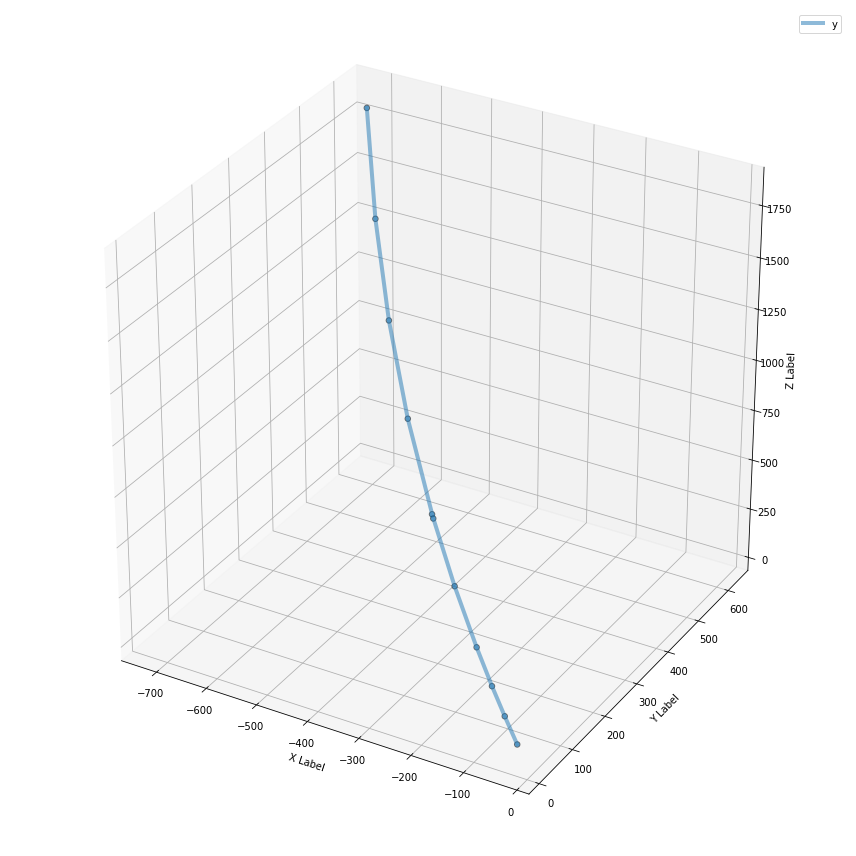

In [48]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data.x, data.y, data.z, '-', alpha=0.5, lw=4)
ax.scatter(data.x, data.y, data.z, marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
#ax.view_init(elev=90, azim=0)
ax.legend()

fig.tight_layout()
plt.show()

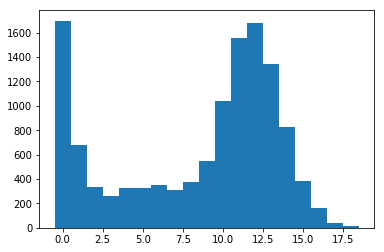

In [55]:
plt.hist(particles[particles['particle_id'] != 0]['nhits'], bins=[x-0.5 for x in range(0, 20)])
plt.show()

In [68]:
len(particles[particles['particle_id']!= 0])

12263

In [70]:
hits.shape

(120939, 7)

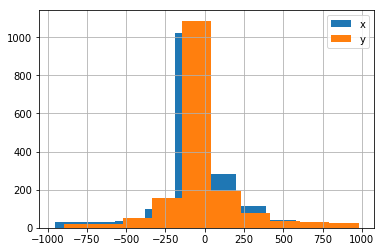

In [62]:
plt.hist(particles[particles['nhits'] == 0]['vx'], label='x')
plt.hist(particles[particles['nhits'] == 0]['vy'], label='y')
#plt.hist(particles[particles['nhits'] == 0]['vz'], label='z')
plt.legend()
plt.grid()
plt.show()

In [63]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [65]:
training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ['NN', 'V', 'DET', "NN"])
]

In [66]:
word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
        
print(word_to_ix)

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


In [67]:
tag_to_ix = {"DET": 0, "NN": 1, 'V': 2}
embedding_dim = 6
hidden_dim = 6

In [71]:
tags = ["DET", "NN", "V", "DET", "NN"]
target = prepare_sequence(tags, tag_to_ix)
print(target)

tensor([ 0,  1,  2,  0,  1])


In [97]:
pp = particles[(particles['particle_id'] != 0) & (particles['nhits'] > 6)].sample(2)['particle_id']
print(pp)

3460    225192282154860544
6654    540433810710331392
Name: particle_id, dtype: int64


In [84]:
embedding = nn.Embedding(90, embedding_dim)
print(prepare_sequence(training_data[0][0], word_to_ix))
embedding(prepare_sequence(training_data[0][0], word_to_ix))

tensor([ 0,  1,  2,  3,  4])


tensor([[ 0.2736, -0.4026,  1.1018,  0.8074,  1.9880, -0.3079],
        [-0.1436, -0.3819,  2.6041, -1.8029, -0.7182,  2.0660],
        [-1.1298, -0.1038,  0.8289,  1.2761,  0.9106, -0.7103],
        [-0.0394,  1.3060,  0.4647, -0.8308, -2.0834, -0.8277],
        [ 0.7782, -0.8451,  0.8532, -0.2744, -0.7622,  0.1582]])

In [93]:
pp.iloc[0]

4506417125916672

In [98]:
all_info[all_info['particle_id']==pp.iloc[0]]

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
22000,22001,11.049000,-29.442499,68.850800,8,2,117,225192282154860544,11.044800,-29.444000,68.853699,0.098946,-0.235565,0.604068,0.000009
23805,23806,11.241000,-29.899900,70.023102,8,2,133,225192282154860544,11.237200,-29.901199,70.026497,0.099036,-0.235201,0.604141,0.000008
23860,23861,12.123800,-31.989500,75.400597,8,2,134,225192282154860544,12.123300,-31.990000,75.397697,0.100143,-0.235338,0.603860,0.000007
31610,31611,28.078199,-65.295502,162.212006,8,4,298,225192282154860544,28.084700,-65.292503,162.216003,0.121015,-0.226305,0.602874,0.000006
31622,31623,28.922300,-66.857399,166.386993,8,4,299,225192282154860544,28.924700,-66.855598,166.384003,0.121909,-0.226139,0.602693,0.000005
38688,38689,51.419498,-103.667999,267.570007,8,6,537,225192282154860544,51.412201,-103.672997,267.571014,0.144545,-0.212297,0.602130,0.000005
45535,45536,85.868103,-148.335999,398.358002,8,8,962,225192282154860544,85.868401,-148.335999,398.368988,0.171109,-0.194467,0.600449,0.000004
45539,45540,87.139397,-149.763000,402.803009,8,8,963,225192282154860544,87.133797,-149.768005,402.798004,0.172522,-0.193454,0.600331,0.000004
77296,77297,158.410995,-213.764008,624.119995,13,2,654,225192282154860544,158.404007,-213.766998,624.216003,0.209483,-0.151914,0.598353,0.000003
77307,77308,152.639999,-209.548996,607.500000,13,2,655,225192282154860544,152.666000,-209.533005,607.760986,0.207369,-0.155558,0.598222,0.000003


In [102]:
train1 = all_info[all_info['particle_id']==pp.iloc[1]][['x', 'y', 'z']]

In [107]:
train1_tensor = torch.from_numpy(train1.values)
print(train1_tensor)

tensor([[  13.4408,   28.9720,    0.6906],
        [  14.5282,   31.1657,    0.6906],
        [  13.2252,   28.5263,    0.6594],
        [  14.2829,   30.6836,    0.7156],
        [  32.3045,   64.3608,    0.9156],
        [  32.0521,   63.9259,    0.8844],
        [  55.4264,  100.9600,    1.1656],
        [  89.3630,  146.2590,    1.5594],
        [ 155.3400,  215.5720,    1.8000],
        [ 150.5790,  211.2240,    1.8000],
        [ 365.7410,  341.6600,    4.2000],
        [ 545.4040,  378.3470,    5.4000],
        [ 539.1130,  377.9400,    5.4000],
        [ 739.6850,  359.5510,    5.4000],
        [ 995.5260,  226.2090,    5.4000]])


In [116]:
inp = nn.Linear(3, hidden_dim)

In [122]:
F.log_softmax(train1_tensor, dim=1)

tensor([[ -15.5312,   -0.0000,  -28.2814],
        [ -16.6375,   -0.0000,  -30.4751],
        [ -15.3011,   -0.0000,  -27.8669],
        [ -16.4007,   -0.0000,  -29.9680],
        [ -32.0563,   -0.0000,  -63.4452],
        [ -31.8738,   -0.0000,  -63.0415],
        [ -45.5336,    0.0000,  -99.7944],
        [ -56.8960,    0.0000, -144.6996],
        [ -60.2320,    0.0000, -213.7720],
        [ -60.6450,    0.0000, -209.4240],
        [  -0.0000,  -24.0810, -361.5410],
        [   0.0000, -167.0570, -540.0040],
        [   0.0000, -161.1730, -533.7130],
        [   0.0000, -380.1340, -734.2850],
        [   0.0000, -769.3170, -990.1260]])

In [123]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        ##self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings = nn.Linear(3, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden
        )
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [152]:
embedding_dim = 6
hidden_dim = 6
total_hits = 30
total_tracks = 3
model = LSTMTagger(embedding_dim, hidden_dim, total_hits, total_tracks)

In [126]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [127]:
with torch.no_grad():
    inputs = train1_tensor
    tag_scores = model(inputs)
    print(tag_scores)

tensor([[-1.1842, -0.7774, -1.4506],
        [-1.2065, -0.7557, -1.4650],
        [-1.2230, -0.7522, -1.4509],
        [-1.2243, -0.7523, -1.4493],
        [-1.1674, -0.7708, -1.4864],
        [-1.1669, -0.7713, -1.4862],
        [-1.1248, -0.7950, -1.4975],
        [-1.1062, -0.8065, -1.5016],
        [-1.1028, -0.8087, -1.5023],
        [-1.1028, -0.8087, -1.5023],
        [-1.1027, -0.8088, -1.5023],
        [-1.1023, -0.9501, -1.2687],
        [-1.1165, -0.9857, -1.2060],
        [-1.2723, -1.6559, -0.6369],
        [-1.2734, -1.6583, -0.6355]])


In [135]:
all_pps = np.unique(particles['particle_id'])
particle_id_map = {all_pps[x]:x for x in range(len(all_pps))}

In [149]:
def tag_hits(seq, to_tag):
    idxs = [to_tag[w[0]] for w in seq.values]
    print(idxs)
    return torch.tensor(idxs, dtype=torch.long)

In [138]:
train1 = all_info[all_info['particle_id']==pp.iloc[1]][['particle_id', 'x', 'y', 'z']]

In [150]:
train1_tag = tag_hits(train1, particle_id_map)

[6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657, 6657]


In [151]:
len(train1_tag)

15

In [153]:
append1 = all_info.sample(total_hits - len(train1_tag))[['particle_id', 'x', 'y', 'z']]

In [159]:
t1 = train1.append(append1)
tag1 = 

30